In [1]:
import networkx as nx
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
## Multiprocessing Package
from multiprocessing import cpu_count
from dask.distributed import Client, progress
import dask
client = Client(threads_per_worker=2)
client

/home/michael/miniconda3/envs/dask/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:36725 Dashboard: http://127.0.0.1:34765/status,Cluster Workers: 8 Cores: 16 Memory: 33.60 GB


In [91]:
#########################################################################################
############################### Network Helper Functions  ###############################
#########################################################################################

'''
    Global Variables
    N      ::  Number of nodes
    phi    ::  Threshold value
    label  ::  Attribute name of influence
    time   ::  Attribute name of time
'''

def set_time(G, value, node=None):
    '''
        Set the time of an individual node in a network G 
        to value or set the time of all nodes to value.
        G      ::  a networkx graph
        node   ::  a reference to a node in G
        value  ::  a non-negative integer
    '''
    if node:
        G.nodes[node][time] = value
    else:
        time_attrib = {i : value for i in range(N)}
        nx.set_node_attributes(G,time_attrib, time)


def set_influence(G, value, node=None):
    '''
        Set the influence of an individual node in a network G 
        to value or set the influence of all nodes to value.
        G      ::  a networkx graph
        node   ::  a reference to a node in G
        value  ::  an integer 0 or 1
    '''
    if node:
        G.nodes[node][label] = value
    else:
        influence_attrib = { i : value for i in range(N) }
        nx.set_node_attributes(G,influence_attrib, label)
        
def get_is_influenced(G, node):
    '''
        Returns if node in G is influenced.
    '''
    return G.nodes[node][label]
        
def get_number_influenced(G):
    '''
        Get the number of influenced nodes.
    '''
    return sum(nx.get_node_attributes(G, label).values())

#################################################################################
########################## Simulation Helper Functions ##########################
#################################################################################

def get_uninfluenced_neighbours(G, nodes):
    '''
        Return a set of neighbours of nodes
        that are uninfluenced.
    '''
    neighbours = set()
    for node in nodes:
        friends = list(G.neighbors(node))
        neighbours.update([friend for friend in friends if G.nodes[friend][label] == 0])
    return neighbours

def update_influence(G, node, phi, time):
    '''
        Update a node's influence status.
        Returns true or false.
    '''
    if get_is_influenced(G, node) == 1:
        return False
    else:
        friends = list(G.neighbors(node))
        num_friends = len(friends)
        
        ## Node with no friends cannot be influenced
        if num_friends == 0:
            return False
        
        ## Calculate the number of friends who can influence 
        ## current node and compare with threshold.
        num_influenced = sum([1 for friend in friends if G.nodes[friend][label] == 1])
        if (num_influenced/num_friends) > phi:
            set_influence(G, 1, node)
            set_time(G, time, node)
            return True
        return False
    
def simulate_spread(G, initial_node, phi):
    '''
        Simulates the spread of influence from initial node under threshold phi.
        Tracks the component of influenced nodes, determines the uninfluenced 
        neighbours of this component, and determines whether the neighbours 
        can be influenced. 
        Returns the number of influenced nodes and expected time to be influenced.
    '''
    
    G_tmp = G.copy()
    set_influence(G_tmp, 1, initial_node)

    t = [0 for _ in range(N)]
    time, num_influenced = 1, 1
    t[0] = 1
    influenced_nodes = set([initial_node])
    
    ## Iteratively compute the number of nodes (update t[time]) influenced at
    ## each time step until a time step is reached where no neighbours to
    ## the influenced component can be influenced.
    while num_influenced > 0:
        num_influenced = 0
        neighbours = get_uninfluenced_neighbours(G_tmp, influenced_nodes)
        for node in neighbours:
            if update_influence(G_tmp, node, phi, time):
                num_influenced += 1
                influenced_nodes.add(node)
        t[time] = num_influenced
        time += 1
    
    ## Determine the empirical expected time to be influenced
    expected_time = sum([i * t[i] for i in range(N)])/N
#     return (len(influenced_nodes), expected_time)
    return G_tmp

In [92]:
#################################################################################
############################# Simulation  Functions #############################
#################################################################################

def run_simulation_RG(p):
    '''
        Simulation of Poisson/Binomial Random Graph
        Returns the average size of influenced nodes and average expected 
        time to be influenced from 
            - influential nodes
            - normal nodes
    '''
    G = nx.erdos_renyi_graph(N,p)
    set_influence(G, 0)
    set_time(G, 0)
    
    ## Retrieve influential nodes - top q% and non-influential nodes
    degree_ordered_nodes = sorted(list(G.nodes()), key=lambda x: G.degree(x), reverse=True)
    influential_nodes = degree_ordered_nodes[:int(q*N)]
    normal_nodes = degree_ordered_nodes[int(q*N):]
        
    influential_S = []
    influential_t = []
    normal_S = []
    normal_t = []
    
    ## Calculate the number of influenced nodes (S) and expected time of influenced nodes
    ## for each influential node
    for node in influential_nodes:
        S, t = simulate_spread(G, node, phi)
        influential_S.append(S)
        influential_t.append(t)
        
    ## Calculate the number of influenced nodes (S) and expected time of influenced nodes
    ## for each normal node
    for node in normal_nodes:
        S, t = simulate_spread(G, node, phi)
        normal_S.append(S)
        normal_t.append(t)
    
    return [np.mean(influential_S), np.mean(normal_S), np.mean(influential_t), np.mean(normal_t)]

# Simulation of Poisson Random Graph

The following code is for simulating and measuring the cascade of influentials.

In [9]:
######################################################################
############################# Parameters #############################
######################################################################

N = 1000
q = 0.1   
phi = 0.15
max_n_avg = 10
increment = 0.2
num_simulations = 15
label = 'is_influenced'
time = 'time'

n_avg = np.arange(1, max_n_avg, increment)
p = [avg/(N-1) for avg in n_avg]
n = len(p)

In [ ]:

N=1000
pr = 0.1

In [ ]:
G = nx.erdos_renyi_graph(N,pr)
set_influence(G, 0)
set_time(G, 0)

In [ ]:
x = []
for node in tqdm(G.nodes()):
    G_tmp = simulate_spread(G.copy(), node, phi)
    uninfluenced = []
    for node in G_tmp.nodes():
        if get_is_influenced(G_tmp, node) == 0:
            uninfluenced.append(node)
    x.append(len(uninfluenced))
    for node in uninfluenced:
        if update_influence(G_tmp, node, phi, 0):
            print("HHH")

In [ ]:
get_number_influenced(G_tmp)

In [ ]:
x[-1]

In [ ]:
len(G.nodes())

In [ ]:
get_number_influenced(G_tmp)

In [17]:
list(nx.get_node_attributes(G, label).values())

dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

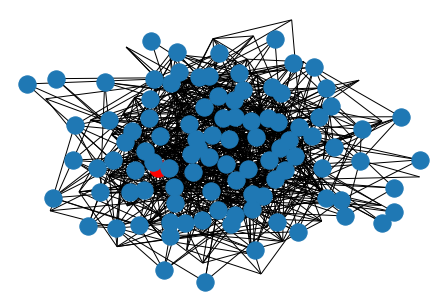

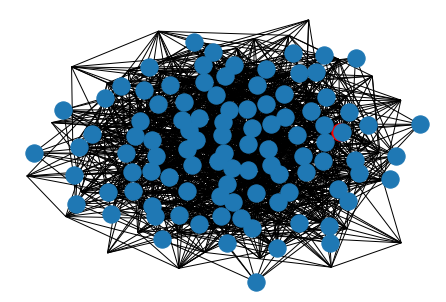

In [114]:
G = nx.erdos_renyi_graph(100,0.15)
set_influence(G, 0)
set_time(G, 0)
phi = 0.000001

G_tmp = G.copy()
initial_node = 1
set_influence(G_tmp, 1, initial_node)

t = [0 for _ in range(N)]
time, num_influenced = 1, 1
t[0] = 1
influenced_nodes = set([initial_node])

nx.draw(G, nodelist=influenced_nodes, node_color='r')
nx.draw(G)

In [93]:
num_influenced = 0
neighbours = get_uninfluenced_neighbours(G_tmp, influenced_nodes)
for node in neighbours:
    if update_influence(G_tmp, node, phi, time):
        num_influenced += 1
        influenced_nodes.add(node)
t[time] = num_influenced
time += 1
print((num_influenced))

0


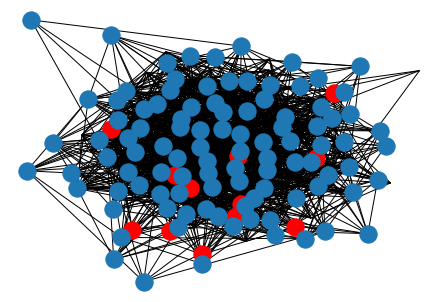

In [94]:
nx.draw(G, nodelist=influenced_nodes, node_color='r')
nx.draw(G)

In [103]:
influenced_nodes

{0, 1, 5, 19, 21, 25, 47, 52, 53, 63, 81, 94}

In [106]:
neighbours = set()
for node in influenced_nodes:
    friends = list(G.neighbors(node))
    neighbours.update([friend for friend in friends if G.nodes[friend][label] == 0])

In [109]:
friends

[0, 1, 3, 8, 10, 12, 22, 23, 25, 27, 33, 36, 43, 67, 87, 88, 92, 94]

In [110]:
[friend for friend in friends if G.nodes[friend][label] == 0]

[0, 1, 3, 8, 10, 12, 22, 23, 25, 27, 33, 36, 43, 67, 87, 88, 92, 94]

In [116]:
G.nodes[1]

{'is_influenced': 0, 5: 0}

In [ ]:
%%time
pool = []
for i in tqdm(range(num_simulations)):
    for j in range(n):
        pool.append(dask.delayed(run_simulation_RG)(p[j]))

results = dask.compute(pool)

In [ ]:
tmp = np.array(results[0])
dims = (num_simulations, n)
names = ["Influential", "Normal"]

S_influential = np.reshape(tmp[:,0], dims)
t_influential = np.reshape(tmp[:,1], dims)
S_normal = np.reshape(tmp[:,2], dims)
t_normal = np.reshape(tmp[:,3], dims)

# Averaged Time of Influenced Nodes
T_influential = np.apply_along_axis(np.mean, 0, t_influential)
T_normal = np.apply_along_axis(np.mean, 0, t_normal)

# Number of Nodes of Network Influenced
N_influential = np.apply_along_axis(np.mean, 0, S_influential)
N_normal = np.apply_along_axis(np.mean, 0, S_normal)

# Proportion of Network Influenced
P_influential = [x/N for x in N_influential]
P_normal = [x/N for x in N_normal]

### Plotting

In [ ]:
plt.plot(n_avg, N_influential, "-s")
plt.plot(n_avg, N_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Number of Nodes Influenced")
plt.legend(names)

In [ ]:
plt.plot(n_avg, P_influential, "-o")
plt.plot(n_avg, P_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Percentage of Network Influenced")
plt.legend(names)

In [ ]:
plt.plot(n_avg, T_influential, "-o")
plt.plot(n_avg, T_normal, "-o")
plt.ylabel("Average Time of Influenced")
plt.xlabel("Average Degree")
plt.title("Comparison of Average Influenced Time against Average Degree")
plt.legend(names)